In [1]:
import sys; sys.path.append('/rds/general/user/cb2714/home/01_wwa/'); from wwa import *

xn, xx, yn, yx = [-145,-50,40,80]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define projection to be used for all maps
cproj = cartopy.crs.epsg(3347)  # native EPSG of homogenous fire regions
cproj.bounds = (3393069.0021458385, 9436930.849558635, 750000, 4340847.387925235)      # modify bounds to focus on region of interest

hfrz = gpd.read_file("sf_hfrz")
provinces = gpd.read_file("sf_provinces").to_crs(cproj).set_index("PRENAME")

warnings.filterwarnings("ignore", message = ".+input coordinates to pcolormesh.+")

In [17]:
!cd data; wget https://climexp.knmi.nl/data/era5_z500_daily_-160--40E_40-75N.nc

--2024-03-01 15:35:51--  https://climexp.knmi.nl/data/era5_z500_daily_-160--40E_40-75N.nc
Resolving climexp.knmi.nl (climexp.knmi.nl)... 2a0c:5bc0:4c:ff::9126:ce95, 145.38.206.149
Connecting to climexp.knmi.nl (climexp.knmi.nl)|2a0c:5bc0:4c:ff::9126:ce95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1426136278 (1.3G) [application/x-netcdf]
Saving to: ‘era5_z500_daily_-160--40E_40-75N.nc.1’

era5_z500_daily_-16 100%[===================>]   1.33G   306MB/s    in 4.6s    

2024-03-01 15:35:58 (299 MB/s) - ‘era5_z500_daily_-160--40E_40-75N.nc.1’ saved [1426136278/1426136278]



---
---
# **PPA / Z500 anomalies**

## **Check: is detrending the Z500 heights using GMST likely to work?**
_Have also downloaded time series of mean monthly air temp over the same region: would that be better?_

In [5]:
da = xr.open_dataset("data/era5_z500_daily_-160--40E_40-75N.nc").z500
ts = da.mean(["lat", "lon"])
ts_ann = ts.resample(time = "AS-JAN").mean()
ts_ann = ts_ann.assign_coords(time = ts_ann.time.dt.year).rename("year")

In [48]:
gmst = pd.read_fwf("ts/gmst.dat", comment = "#", header = None, names = ["year", "gmst"], index_col = "year")[14:-10]
gmst.gmst = [float(v) for v in gmst.gmst.values]
gmst.index = [int(y) for y in gmst.index]

In [58]:
df = pd.merge(gmst, ts_ann.rename("z500").to_dataframe(), left_index = True, right_index = True)

In [49]:
((ts_ann - ts_ann.mean()) / ts_ann.std()).plot()
((gmst - gmst.mean()) / gmst.std()).plot(ax = plt.gca())

<AxesSubplot: >

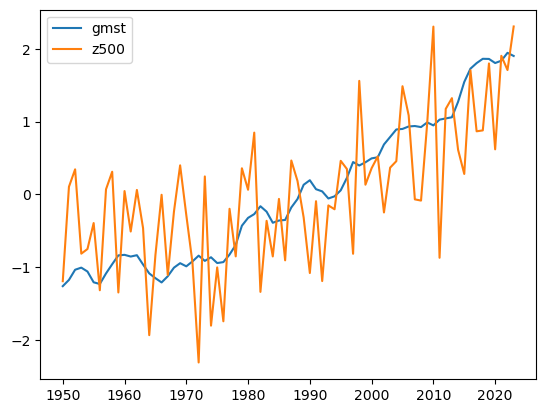

In [66]:
((df - df.mean(axis = 0)) / df.std(axis = 0)).plot()

---
# **Pre-process ERA5 FWI data for follow-up study**

_FWI data downloaded from https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.0e89c522 in decadal blocks_


In [13]:
# Compile FWI data into a single file

fl = sorted(glob.glob("../../00_WWA_project_folder/live/data/era5_fire/*consolidated*.nc"))

fwi_cns = [wrap_lon(xr.open_dataset(fnm)).fwinx.sel(longitude = slice(xn, xx), latitude = slice(yn, yx)).reset_coords(drop = True) for fnm in fl]

int_start = (fwi_cns[-1].time[-1]+1)

fwi_int = wrap_lon(xr.open_dataset("../../00_WWA_project_folder/live/data/era5_fire/era5_025_fwi_intermediate.nc"))
fwi_int = fwi_int.fwinx.sel(longitude = slice(xn, xx), latitude = slice(yn, yx), time = slice(int_start, None)).reset_coords(drop = True)

fwi = xr.concat(fwi_cns + [fwi_int], "time")
fwi = fwi.assign_attrs(note = "Intermediate data after "+str(fwi_int.time.min().values)[:10])

fwi.to_netcdf("data/era5_fwi_"+"_".join([str(d) for d in [xn,xx,yn,yx]])+".nc")

## **Cut into 5-year blocks for easier downloading**

In [14]:
# load FWI & mask Canada
fwi = xr.open_dataset("data/era5_fwi_"+"_".join([str(d) for d in [xn,xx,yn,yx]])+".nc").fwinx.sel(time = slice("1950",None))

# adjust dates to midnight instead of midday for easier matching later
fwi = fwi.assign_coords(time = fwi.time.dt.floor("D"))

rm_canada = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.mask_3D(fwi.longitude, fwi.latitude).sel(region = 202).reset_coords(drop = True)
fwi = fwi.where(rm_canada == 1).dropna("latitude", "all").dropna("longitude", "all")

In [15]:
for y in range(1950,2025,5):
    
    fwi_y = fwi.sel(time = slice(str(y), str(y+4))).rename("fwi")
    fwi_y.to_netcdf("data/era5_fwi_"+str(fwi_y.time.min().dt.year.values)+"-"+str(fwi_y.time.max().dt.year.values)+".nc")
    
    dsr = ((fwi_y ** 1.77) * 0.0272).rename("dsr")
    dsr.to_netcdf("data/era5_dsr_"+str(fwi_y.time.min().dt.year.values)+"-"+str(fwi_y.time.max().dt.year.values)+".nc")

## **Mean & SD of DSR over reference period**

In [44]:
# load FWI & mask Canada
fwi = xr.open_dataset("data/era5_fwi_"+"_".join([str(d) for d in [xn,xx,yn,yx]])+".nc").fwinx.sel(time = slice("1950",None))

rm_canada = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.mask_3D(fwi.longitude, fwi.latitude).sel(region = 202).reset_coords(drop = True)
fwi = fwi.where(rm_canada == 1).dropna("latitude", "all").dropna("longitude", "all")

# Calculate monthly mean DSR
dsr = (fwi ** 1.77) * 0.0272

In [45]:
# save monthly mean & SD
mdsr = dsr.resample(time = "MS").mean()
mdsr_mean = mdsr.sel(time = slice("1991", "2020")).mean("time").rename("dsr_mean")
mdsr_sd = mdsr.sel(time = slice("1991", "2020")).std("time").rename("dsr_sd")
xr.merge([mdsr_mean, mdsr_sd]).to_netcdf("era5_dsr-mean-sd_monthly.nc")

In [46]:
# save annual mean & SD
adsr = dsr.resample(time = "AS-JAN").mean()
adsr_mean = adsr.sel(time = slice("1991", "2020")).mean("time").rename("dsr_mean")
adsr_sd = adsr.sel(time = slice("1991", "2020")).std("time").rename("dsr_sd")
xr.merge([adsr_mean, adsr_sd]).to_netcdf("era5_dsr-mean-sd_yearly.nc")

In [47]:
# save daily mean & SD
dsr_mean = dsr.sel(time = slice("1991", "2020")).mean("time").rename("dsr_mean")
dsr_sd = dsr.sel(time = slice("1991", "2020")).std("time").rename("dsr_sd")
xr.merge([dsr_mean, dsr_sd]).to_netcdf("era5_dsr-mean-sd_daily.nc")

## **Lambert coordinates and regionmask**

In [15]:
def latlon_to_lambert(da):
    
    # convert dataArray to dataframe
    df = da.to_dataframe().reset_index()
    
    # convert to geoDataFrame, reproject points to Statistics Canada Lambert 
    gdf = gpd.GeoDataFrame(df[df.columns[-1]], geometry = gpd.points_from_xy(df.longitude, df.latitude))
    gdf = gdf.set_crs(epsg = 4326).to_crs(epsg = 3347)
    
    x = np.reshape(np.array(gdf.geometry.x), da.shape)
    y = np.reshape(np.array(gdf.geometry.y), da.shape)
    
    return x,y

In [106]:
tmplt = xr.open_dataset("data/era5_dsr_1950-1954.nc").isel(time = 0, drop = True).dsr

# create regionmask
sf = gpd.read_file("sf_hfrz").to_crs(epsg = 4326)
rm = regionmask.mask_3D_geopandas(sf, tmplt.longitude, tmplt.latitude)
rm = rm.assign_coords(region_name = ("region", sf.NAMES_SHOR))

# add Lambert coordinates
xy = latlon_to_lambert(tmplt)
rm = rm.assign_coords({k : (["latitude", "longitude"], v) for k,v in zip(["x","y"], xy)})

rm.to_netcdf("hfrz-mask_era5-025.nc")

## **Time series per HFRZ**

### **Cumulative DSR**

In [21]:
# load data & assign coordinates to HFRZs
dsr = xr.open_mfdataset("data/era5_dsr_*.nc").dsr

rm = xr.open_dataset("hfrz-mask_era5-025.nc").mask
dsr = dsr.where(rm == 1)

In [22]:
# get daily time series per HFRZ
dsr_ts = dsr.mean(["latitude", "longitude"]).load()

In [23]:
# cumulative DSR - for whole year and for fire season (April-October)
cdsr = dsr_ts.resample(time = "AS-JAN").sum()
cdsr_fs = dsr_ts.sel(time = [m in [4,5,6,7,8,9,10] for m in dsr_ts.time.dt.month]).resample(time = "AS-JAN").sum()
cdsr, cdsr_fs = [da.assign_coords(time = da.time.dt.year).rename(time = "year") for da in [cdsr, cdsr_fs]]


In [49]:
# save as csv
for i in range(16):
    rnm = str(cdsr.sel(region = i).region_name.values)
    cdsr.sel(region = i).reset_coords(drop = True).to_pandas().to_csv("ts/era5_cumDSR_"+rnm+".csv")
    cdsr_fs.sel(region = i).reset_coords(drop = True).to_pandas().to_csv("ts/era5_cumDSR-fs_"+rnm+".csv")

### **PPA**

In [43]:
# load data & assign coordinates to HFRZs
ppa = xr.open_mfdataset("ppa/PPA_mask_*.nc").z
rm = regionmask.mask_3D_geopandas(hfrz.to_crs(epsg = 4326), ppa.longitude, ppa.latitude)

ppa = ppa.where(rm == 1)

# get daily time series per HFRZ
ppa_ts = ppa.mean(["latitude", "longitude"]).load()

In [51]:
# cumulative PPA for each fire season (April-October)
cppa_fs = ppa_ts.resample(time = "AS-JAN").sum()

In [54]:
# save as csv
for i in range(16):
    rnm = hfrz.loc[i, "NAMES_SHOR"]
    cppa_fs.sel(region = i).reset_coords(drop = True).to_pandas().to_csv("ts/era5_PPA-fs_"+rnm+".csv")

---
# **Exploratory analysis**



## **cumDSR for all of Canada**

In [111]:
dsr_canada = xr.concat([xr.open_dataset(fnm).dsr for fnm in sorted(glob.glob("data/era5_dsr_*.nc"))], "time")

In [156]:
a = xr.ones_like(dsr_canada.isel(time = 0)).where(dsr_canada.sum("time") > 0).sum()
dsr_ts = dsr_canada.sum(["latitude", "longitude"]) / a

cdsr_canada = xr.concat([dsr_ts.sel(time = str(y)).cumsum("time") for y in range(1950,2024)], "time")

In [157]:
# when were various thresholds exceeded in 2023?
hist_max = cdsr_canada.sel(time = slice(None, "2022")).max()
hist_q95 = cdsr_canada.sel(time = slice(None, "2022")).groupby("time.dayofyear")[365].quantile(0.95)
hist_med = cdsr_canada.sel(time = slice(None, "2022")).groupby("time.dayofyear")[365].median()

ex_max, ex_q95, ex_med = [(cdsr_canada.sel(time = "2023") < th).idxmin() for th in [hist_max, hist_q95, hist_med]]

print("1950-2022 median exceeded on", ex_med.dt.strftime("%d %B").values)
print("1950-2022 q95 exceeded on", ex_q95.dt.strftime("%d %B").values)
print("1950-2022 maximum exceeded on", ex_max.dt.strftime("%d %B").values)

1950-2022 median exceeded on 23 July
1950-2022 q95 exceeded on 26 August
1950-2022 maximum exceeded on 12 September


In [208]:
# split by HFRZ
rm = xr.open_dataset("hfrz-mask_era5-025.nc").mask

zz = dsr_canada.sel(time = "2023").where(rm.sum("region") == 0).sum(["latitude", "longitude"]).cumsum("time").expand_dims(region = [16]).assign_coords(region_name = ("region", ["ZZ"]))
cdsr_hfrz = xr.concat([dsr_canada.sel(time = "2023").where(rm.sel(region = i) == 1).sum(["latitude", "longitude"]).cumsum("time") for i in range(16)] + [zz], "region") / a

cdsr_hfrz = cdsr_hfrz.sortby(cdsr_hfrz.region_name).assign_coords(region = range(0,17))

cum_cdsr_hfrz = cdsr_hfrz.cumsum("region")

Text(0.5, 1.04, 'DSR over all of Canada (ERA5, 1950-2023)')

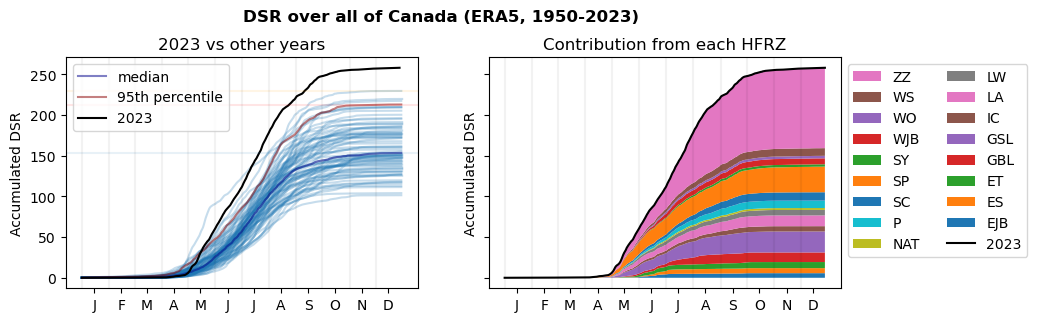

In [216]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (10,3), dpi = 100, sharey = True)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[0]
for y in range(1950,2022):
    cdsr_y = cdsr_canada.sel(time = str(y))
    ax.plot(cdsr_y.time.dt.dayofyear, cdsr_y, color = "tab:blue", alpha = 0.25)

# 95th percentile & median of cumsum
ax.plot(cdsr_canada.sel(time = "2022").time.dt.dayofyear, cdsr_canada.sel(time = slice(None, "2022")).groupby("time.dayofyear").median()[:-1],
        color = "darkblue", alpha = 0.5, label = "median")
ax.plot(cdsr_canada.sel(time = "2022").time.dt.dayofyear, cdsr_canada.sel(time = slice(None, "2022")).groupby("time.dayofyear").quantile(0.95)[:-1],
        color = "darkred", alpha = 0.5, label = "95th percentile")

y = 2023
cdsr_y = cdsr_canada.sel(time = str(y))
ax.plot(cdsr_y.time.dt.dayofyear, cdsr_y, color = "k", alpha = 1, label = "2023")

ax.set_title("2023 vs other years")
ax.legend()

ax.axhline(hist_max, alpha = 0.1, color = "orange")
ax.axhline(hist_q95, alpha = 0.1, color = "red")
ax.axhline(hist_med, alpha = 0.1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[1]
y = 2023
cdsr_y = cdsr_canada.sel(time = str(y))
ax.plot(cdsr_y.time.dt.dayofyear, cdsr_y, color = "k", alpha = 1, label = "2023")

ax.fill_between(x = cum_cdsr_hfrz.time.dt.dayofyear, y1 = 0, y2 = cum_cdsr_hfrz.sel(region = 0), label = cum_cdsr_hfrz.region_name.values[0])
for i in range(16):
    ax.fill_between(x = cum_cdsr_hfrz.time.dt.dayofyear, y1 = cum_cdsr_hfrz.sel(region = i), y2 = cum_cdsr_hfrz.sel(region = i+1), label = cum_cdsr_hfrz.region_name.values[i+1])

ax.set_title("Contribution from each HFRZ")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles [::-1], labels [::-1], bbox_to_anchor = (1,1), ncol = 2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
gridlines = [i+1 for i in range(366) if (days[i].day) == 1]
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

for ax in axs:
    ax.set_ylabel("Accumulated DSR")
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.suptitle("DSR over all of Canada (ERA5, 1950-2023)", y = 1.04, fontweight = "bold")
# plt.savefig("fig/era5_nDSR-canada.png")


## **Cumulative zDSR for all of Canada**

In [225]:
dsr_canada = xr.concat([xr.open_dataset(fnm).dsr for fnm in sorted(glob.glob("data/era5_dsr_*.nc"))], "time")

# normalise DSR using SD of monthly DSR (as suggested by Philippe & Clemence) - not looking at anomalies though, just normalised DSR
ref_dsr = xr.open_dataset("era5_dsr-mean-sd_monthly.nc")
dsr_canada = (dsr_canada) / ref_dsr.dsr_sd

In [226]:
dsr_ts = dsr_canada.mean(["latitude", "longitude"])

cdsr_canada = xr.concat([dsr_ts.sel(time = str(y)).cumsum("time") for y in range(1950,2024)], "time")

In [227]:
# when were various thresholds exceeded in 2023?
hist_max = cdsr_canada.sel(time = slice(None, "2022")).max()
hist_q95 = cdsr_canada.sel(time = slice(None, "2022")).groupby("time.dayofyear")[365].quantile(0.95)
hist_med = cdsr_canada.sel(time = slice(None, "2022")).groupby("time.dayofyear")[365].median()

ex_max, ex_q95, ex_med = [(cdsr_canada.sel(time = "2023") < th).idxmin() for th in [hist_max, hist_q95, hist_med]]

print("1950-2022 median exceeded on", ex_med.dt.strftime("%d %B").values)
print("1950-2022 q95 exceeded on", ex_q95.dt.strftime("%d %B").values)
print("1950-2022 maximum exceeded on", ex_max.dt.strftime("%d %B").values)

1950-2022 median exceeded on 17 July
1950-2022 q95 exceeded on 08 August
1950-2022 maximum exceeded on 15 August


In [228]:
# split by HFRZ
rm = xr.open_dataset("hfrz-mask_era5-025.nc").mask

a = xr.ones_like(dsr_canada.isel(time = 0)).where(dsr_canada.sum("time") > 0).sum()

zz = dsr_canada.sel(time = "2023").where(rm.sum("region") == 0).sum(["latitude", "longitude"]).cumsum("time").expand_dims(region = [16]).assign_coords(region_name = ("region", ["ZZ"]))
cdsr_hfrz = xr.concat([dsr_canada.sel(time = "2023").where(rm.sel(region = i) == 1).sum(["latitude", "longitude"]).cumsum("time") for i in range(16)] + [zz], "region") / a

cdsr_hfrz = cdsr_hfrz.sortby(cdsr_hfrz.region_name).assign_coords(region = range(0,17))

cum_cdsr_hfrz = cdsr_hfrz.cumsum("region")

Text(0.5, 1.04, 'DSR over all of Canada (ERA5, 1950-2023)')

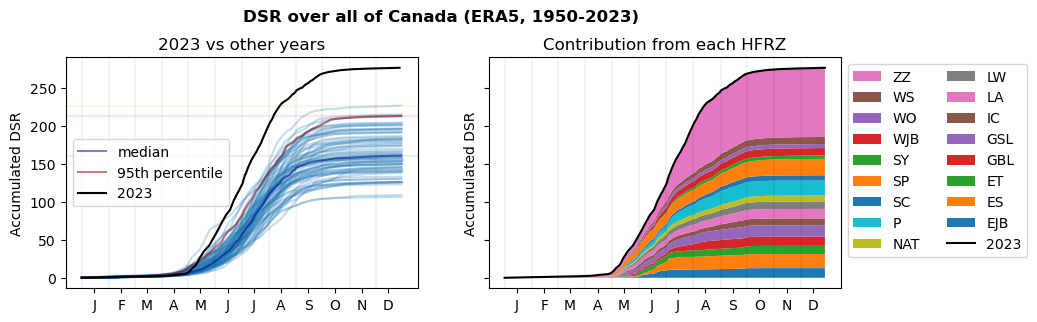

In [229]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (10,3), dpi = 100, sharey = True)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[0]
for y in range(1950,2022):
    cdsr_y = cdsr_canada.sel(time = str(y))
    ax.plot(cdsr_y.time.dt.dayofyear, cdsr_y, color = "tab:blue", alpha = 0.25)

# 95th percentile & median of cumsum
ax.plot(cdsr_canada.sel(time = "2022").time.dt.dayofyear, cdsr_canada.sel(time = slice(None, "2022")).groupby("time.dayofyear").median()[:-1],
        color = "darkblue", alpha = 0.5, label = "median")
ax.plot(cdsr_canada.sel(time = "2022").time.dt.dayofyear, cdsr_canada.sel(time = slice(None, "2022")).groupby("time.dayofyear").quantile(0.95)[:-1],
        color = "darkred", alpha = 0.5, label = "95th percentile")

y = 2023
cdsr_y = cdsr_canada.sel(time = str(y))
ax.plot(cdsr_y.time.dt.dayofyear, cdsr_y, color = "k", alpha = 1, label = "2023")

ax.set_title("2023 vs other years")
ax.legend()

ax.axhline(hist_max, alpha = 0.1, color = "orange")
ax.axhline(hist_q95, alpha = 0.1, color = "red")
ax.axhline(hist_med, alpha = 0.1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[1]
y = 2023
cdsr_y = cdsr_canada.sel(time = str(y))
ax.plot(cdsr_y.time.dt.dayofyear, cdsr_y, color = "k", alpha = 1, label = "2023")

ax.fill_between(x = cum_cdsr_hfrz.time.dt.dayofyear, y1 = 0, y2 = cum_cdsr_hfrz.sel(region = 0), label = cum_cdsr_hfrz.region_name.values[0])
for i in range(16):
    ax.fill_between(x = cum_cdsr_hfrz.time.dt.dayofyear, y1 = cum_cdsr_hfrz.sel(region = i), y2 = cum_cdsr_hfrz.sel(region = i+1), label = cum_cdsr_hfrz.region_name.values[i+1])

ax.set_title("Contribution from each HFRZ")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles [::-1], labels [::-1], bbox_to_anchor = (1,1), ncol = 2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
gridlines = [i+1 for i in range(366) if (days[i].day) == 1]
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

for ax in axs:
    ax.set_ylabel("Accumulated DSR")
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.suptitle("DSR over all of Canada (ERA5, 1950-2023)", y = 1.04, fontweight = "bold")
# plt.savefig("fig/era5_nDSR-canada.png")

---
# **Maps of monthly DSR**


In [47]:
dsr = xr.open_dataset("data/era5_dsr_2020-2023.nc").dsr.sel(time = slice("2023-04", "2023-10")).resample(time = "MS").mean()
dsr = dsr.where(dsr.sum("time") > 0)

rm = xr.open_dataset("hfrz-mask_era5-025.nc").mask
dsr = dsr.assign_coords(x = rm.x, y = rm.y).load()

# also look at normalised DSR anomalies
dsr_ref = xr.open_dataset("era5_dsr-mean-sd_monthly.nc")
dsr_z = (dsr - dsr_ref.dsr_mean) / dsr_ref.dsr_sd

Text(0.5, 0.925, 'Monthly cumulative DSR')

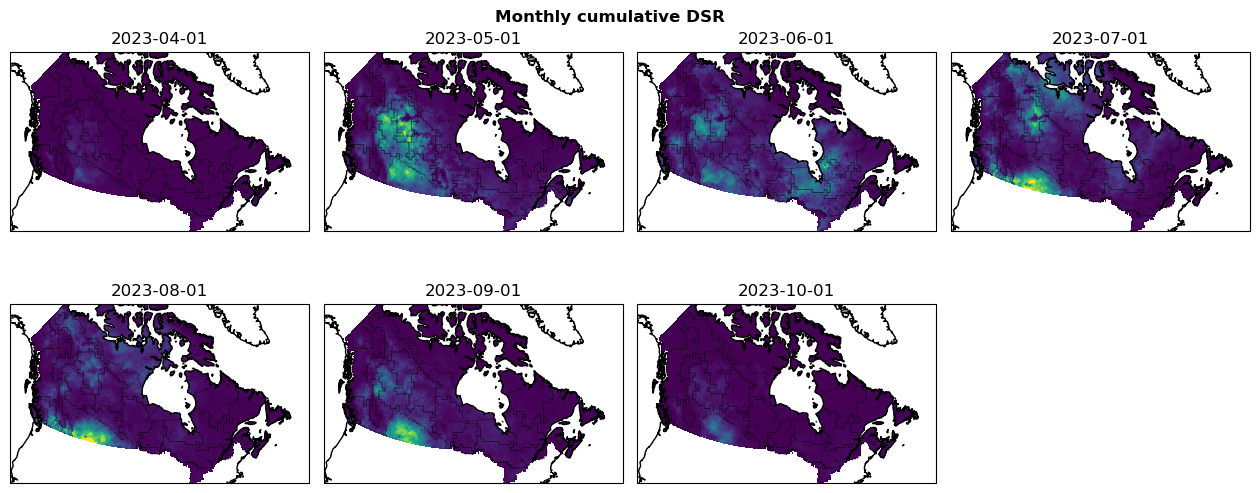

In [48]:
fig, axs = plt.subplots(ncols = 4, nrows = 2, subplot_kw = {"projection" : cproj}, figsize = (16,6), dpi = 100)
plt.subplots_adjust(hspace = 0.2, wspace = 0.05)
plot_kwargs = {"vmin" : 0, "vmax" : 20}
axs[-1,-1].set_axis_off()

for i in range(7):
    ax = fig.axes[i]
    cbar = ax.pcolormesh(dsr.x, dsr.y, dsr.isel(time = i), **plot_kwargs)
    ax.coastlines()
    ax.set_title(dsr.isel(time = i).time.dt.date.values)
    
    hfrz.boundary.plot(ax = ax, color = "k", alpha = 0.4, lw = 0.5)
#     provinces.boundary.plot(ax = ax, color = "k", alpha = 0.4, lw = 0.5)

plt.suptitle("Monthly cumulative DSR", fontweight = "bold", y = 0.925)

Text(0.5, 0.925, 'Monthly standardised anomalies in DSR')

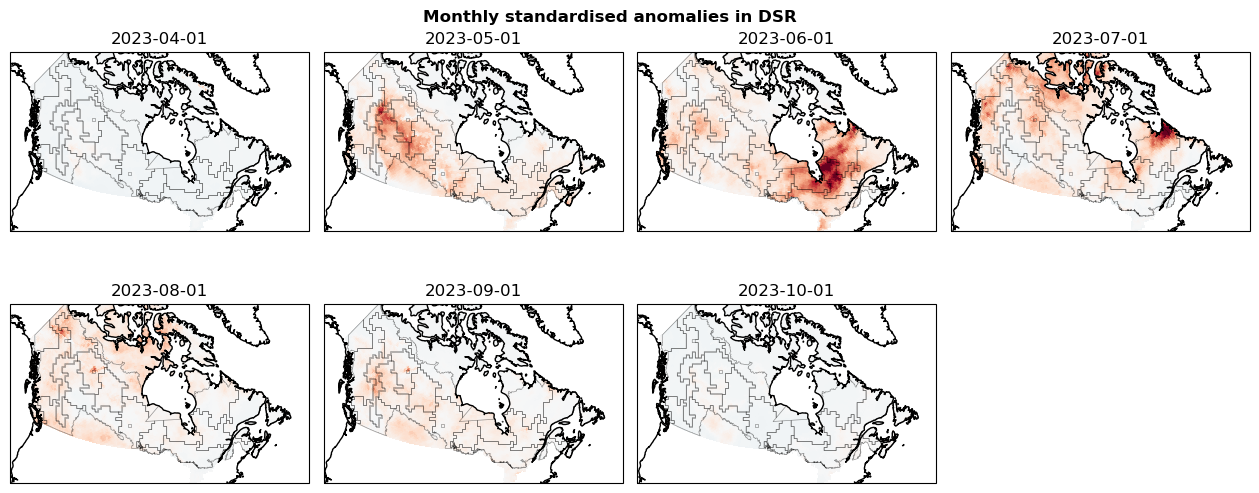

In [46]:
fig, axs = plt.subplots(ncols = 4, nrows = 2, subplot_kw = {"projection" : cproj}, figsize = (16,6), dpi = 100)
plt.subplots_adjust(hspace = 0.2, wspace = 0.05)
plot_kwargs = {"vmin" : -15, "vmax" : 15, "cmap" : "RdBu_r"}
axs[-1,-1].set_axis_off()

for i in range(7):
    ax = fig.axes[i]
    cbar = ax.pcolormesh(dsr_z.x, dsr_z.y, dsr_z.isel(time = i), **plot_kwargs)
    ax.coastlines()
    ax.set_title(dsr.isel(time = i).time.dt.date.values)
    
    hfrz.boundary.plot(ax = ax, color = "k", alpha = 0.4, lw = 0.5)
#     provinces.boundary.plot(ax = ax, color = "k", alpha = 0.4, lw = 0.5)

plt.suptitle("Monthly standardised anomalies in DSR", fontweight = "bold", y = 0.925)

## **Maps of numbers of PPA days**


In [29]:
ppa = xr.open_dataset("ppa/PPA_mask_2023.nc").resample(time = "MS").sum()

xy = latlon_to_lambert(ppa.z.isel(time = 0, drop = True))
ppa = ppa.assign_coords({k : (["latitude", "longitude"], v) for k,v in zip(["x","y"], xy)}).z

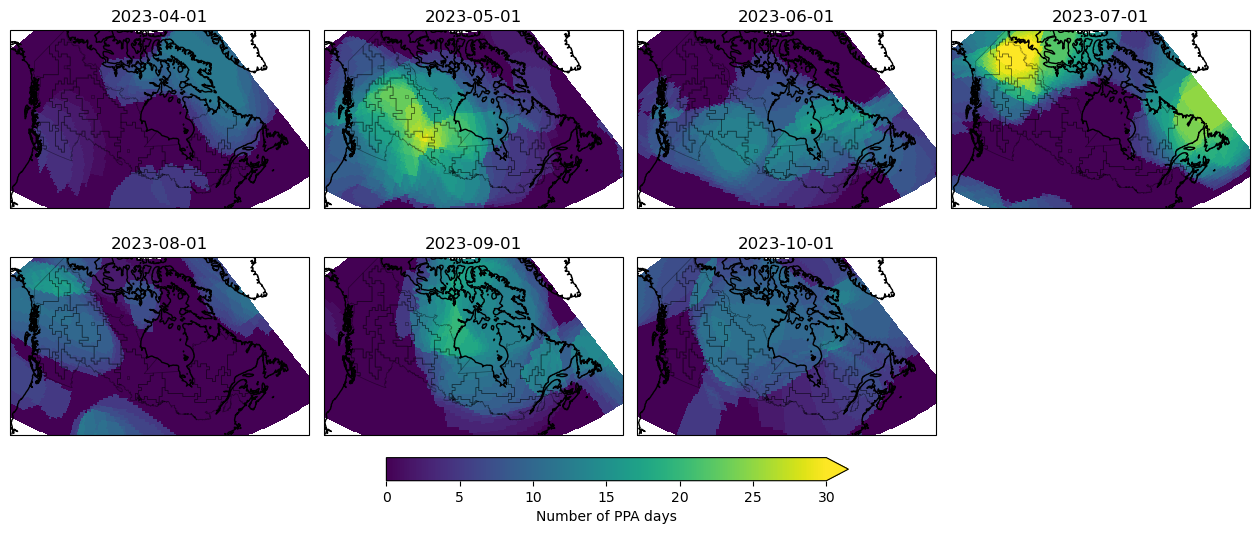

In [43]:
fig, axs = plt.subplots(ncols = 4, nrows = 2, subplot_kw = {"projection" : cproj}, figsize = (16,6), dpi = 100)
plt.subplots_adjust(hspace = 0.2, wspace = 0.05)
plot_kwargs = {"vmin" : 0, "vmax" : 30, "cmap" : "viridis"}

for i in range(7):
    ax = fig.axes[i]
    cbar = ax.pcolormesh(ppa.x, ppa.y, ppa.isel(time = i), **plot_kwargs)
    ax.coastlines()
    ax.set_title(ppa.isel(time = i).time.dt.date.values)
    
    hfrz.boundary.plot(ax = ax, color = "k", alpha = 0.4, lw = 0.5)
#     provinces.boundary.plot(ax = ax, color = "k", alpha = 0.4, lw = 0.5)

axs[-1,-1].set_axis_off()
plt.colorbar(cbar, ax = axs, location = "bottom", label = "Number of PPA days", fraction = 0.05, pad = 0.05, shrink = 0.8, extend = "max")

---
## **Proportion of area in extreme fire risk**

Think this will be quite tricky to communicate - maybe look at proportion of grid cells above threshold for extreme fire risk, or similar?

---
---
# **Original noodlings below this line**


### **Proportion of area above 95th percentile**

Think this will be quite tricky to communicate - maybe look at proportion of grid cells above threshold for extreme fire risk, or similar?

In [ ]:
# compute 95th percentile of 1950-2022 cumDSR for each grid cell & each day of the year
for fnm in sorted(glob.glob("data/era5_ndsr_hfrz-*.nc")):
    
    ds = xr.open_dataset(fnm).ndsr
    
    # 95th percentile of cumsum at each grid cell 
    cs = xr.concat([ds.sel(time = str(y)).cumsum("time") for y in range(1950,2023)], "time")
    q95 = cs.groupby("time.dayofyear").quantile(0.95)
    
    q95.to_netcdf(re.sub("ndsr", "ndsr-q95", fnm))

In [9]:
# identify grid cells where q95 has been exceeded & mark as 1 or 0 (NaN where not in region)
ex_prop = []
for fnm in sorted(glob.glob("data/era5_ndsr_hfrz-*.nc")):
    
    ds = xr.open_dataset(fnm).ndsr.sel(time = "2023").cumsum("time")
    q95 = xr.open_dataset(re.sub("ndsr", "ndsr-q95", fnm)).ndsr
    
    ex_q95 = (ds.groupby("time.dayofyear") - q95)
    ex_q95 = xr.ones_like(ex_q95).where(ex_q95 > 0, 0).where(q95.sum("dayofyear") > 0)
    
    ex_prop.append(ex_q95)

In [51]:
region_size = xr.concat([xr.ones_like(da).where(~np.isnan(da)).isel(time = 0).sum(["latitude", "longitude"]) for da in ex_prop], "region")
ncells = xr.concat(ex_prop, "region").sum(["latitude", "longitude"]) 
cellprop = ncells.sum("region") / region_size.sum("region")
regionprop = (ncells / region_size).reset_coords(drop = True)

In [34]:
cellprop.plot()
plt.ylabel("Proportion exceeding 95th percentile")

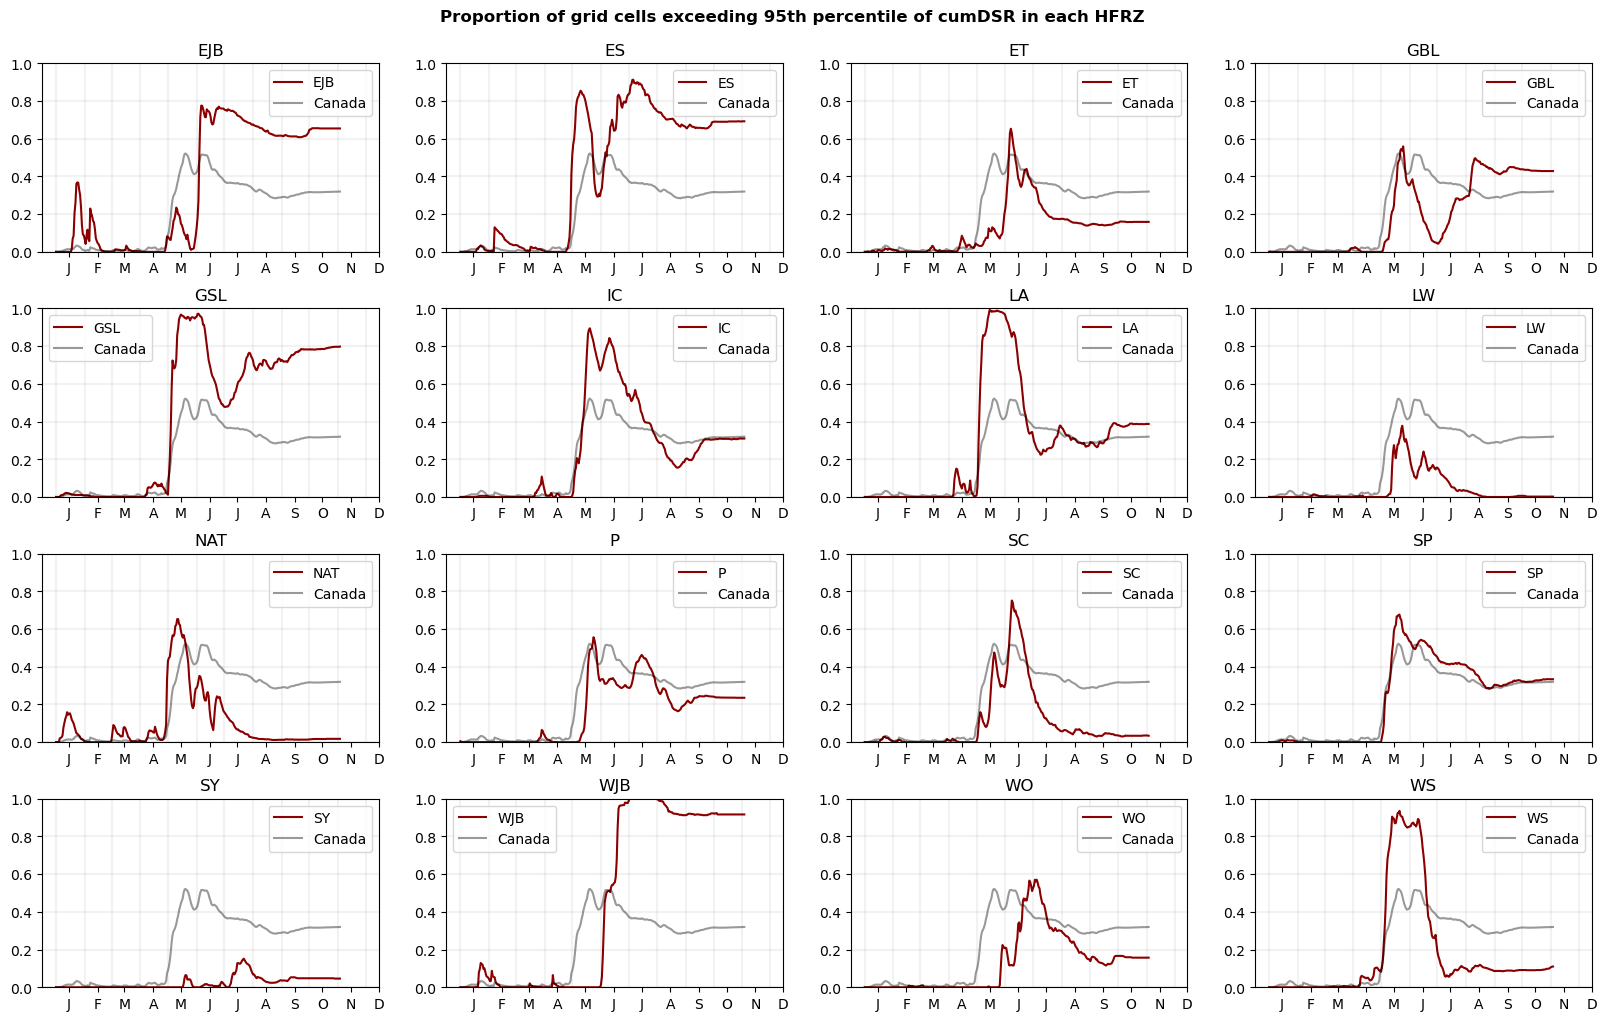

In [67]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100)
plt.subplots_adjust(hspace = 0.3)

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
gridlines = [i+1 for i in range(366) if (days[i].day) == 1]
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

for i in range(16):
    ax = fig.axes[i]
    rnm = regionprop.region.values[i]
    
    ax.plot(regionprop.sel(region = rnm).time.dt.dayofyear, regionprop.sel(region = rnm), color = "darkred", alpha = 1, label = rnm)
    ax.plot(cellprop.time.dt.dayofyear, cellprop, color = "k", alpha = 0.4, label = "Canada")

    ax.set_ylim(0,1)
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]
    [ax.axhline(y, color = "k", alpha = 0.05) for y in np.arange(0,1,0.2)]
    
    ax.set_title(rnm)
    ax.legend()
    
plt.suptitle("Proportion of grid cells exceeding 95th percentile of cumDSR in each HFRZ", fontweight = "bold", y = 0.925)
plt.savefig("fig/era5_cumDSR-exceeding-q95-per-hfrz.png")

---
## **cnDSR per HFRZ**

In [18]:
hfrz_dsr = [xr.open_dataset(fnm).ndsr.mean(["latitude", "longitude"]) for fnm in sorted(glob.glob("data/era5_ndsr_hfrz-*.nc"))]
hfrz_dsr = xr.concat(hfrz_dsr, "region")

In [19]:
hfrz_cdsr = xr.concat([hfrz_dsr.sel(time = str(y)).cumsum("time") for y in range(1950,2023)], "time")

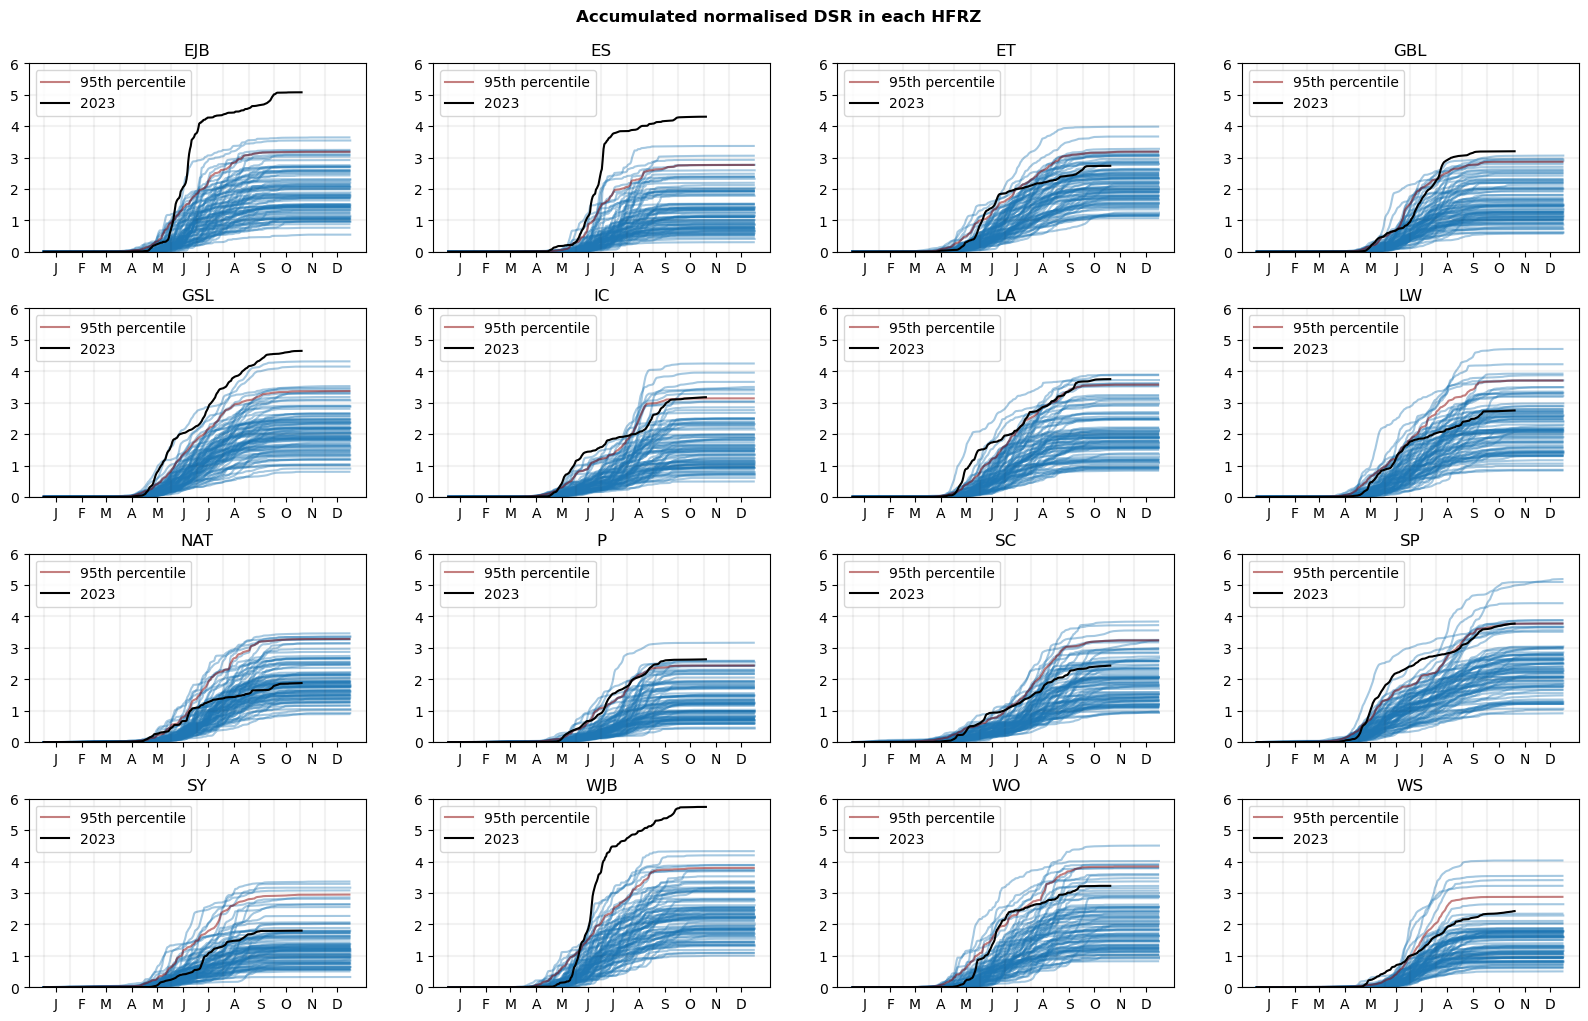

In [52]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100)
plt.subplots_adjust(hspace = 0.3)

for i in range(16):
    ax = fig.axes[i]
    dsr_ts = hfrz_dsr.isel(region = i)
    
    for y in range(1941,2022):
        dsr_y = dsr_ts.sel(time = str(y))
        ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "tab:blue", alpha = 0.4)
    
    # 95th percentile of cumsum
    ax.plot(dsr_ts.sel(time = "2022").time.dt.dayofyear, hfrz_cdsr.isel(region = i).groupby("time.dayofyear").quantile(0.95)[:-1], color = "darkred", alpha = 0.5, label = "95th percentile")
    
    y = 2023
    dsr_y = dsr_ts.sel(time = str(y))
    ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "k", alpha = 1, label = "2023")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]
    [ax.axhline(y, color = "k", alpha = 0.05) for y in range(0,6)]
    ax.set_title(dsr_ts.region.values)
    ax.set_ylim(0,6)
    
    ax.legend(loc = "upper left")
    
plt.suptitle("Accumulated normalised DSR in each HFRZ", fontweight = "bold", y = 0.925)
    
plt.savefig("fig/era5_nDSR-per-hfrz.png")